=== DATA VALIDATION ===
Passenger data range: 2015-01 to 2025-07
Airfare data range: 2015-01 to 2027-09
Fed funds data range: 2015-01 to 2027-10
Unemployment data range: 2015-01 to 2027-08

Rows before dropping NaNs: 110
NaNs in airplane_fare_cpi: 0
NaNs in fed_fund_rate: 0
NaNs in unemployment_rate: 0
Rows after dropping NaNs: 110

=== FORECAST HORIZON ===
Forecast horizon limited to 24 months based on available external data
  - Airfare CPI: 26 months available
  - Fed Funds Rate: 27 months available
  - Unemployment Rate: 25 months available

=== EXOGENOUS FORECAST VALIDATION ===
NaNs in forecast airplane_fare_cpi: 0
NaNs in forecast fed_fund_rate: 0
NaNs in forecast unemployment_rate: 0
✓ No NaNs in exog_forecast - good to proceed!

=== DATE ALIGNMENT CHECK ===
Training data: 110 rows from 2015-01 to 2025-07
Forecast data: 24 rows from 2025-08 to 2027-07
✓ Date alignment confirmed

=== STANDARDIZING EXOGENOUS VARIABLES ===
Training data statistics (after scaling):
       airplane_f

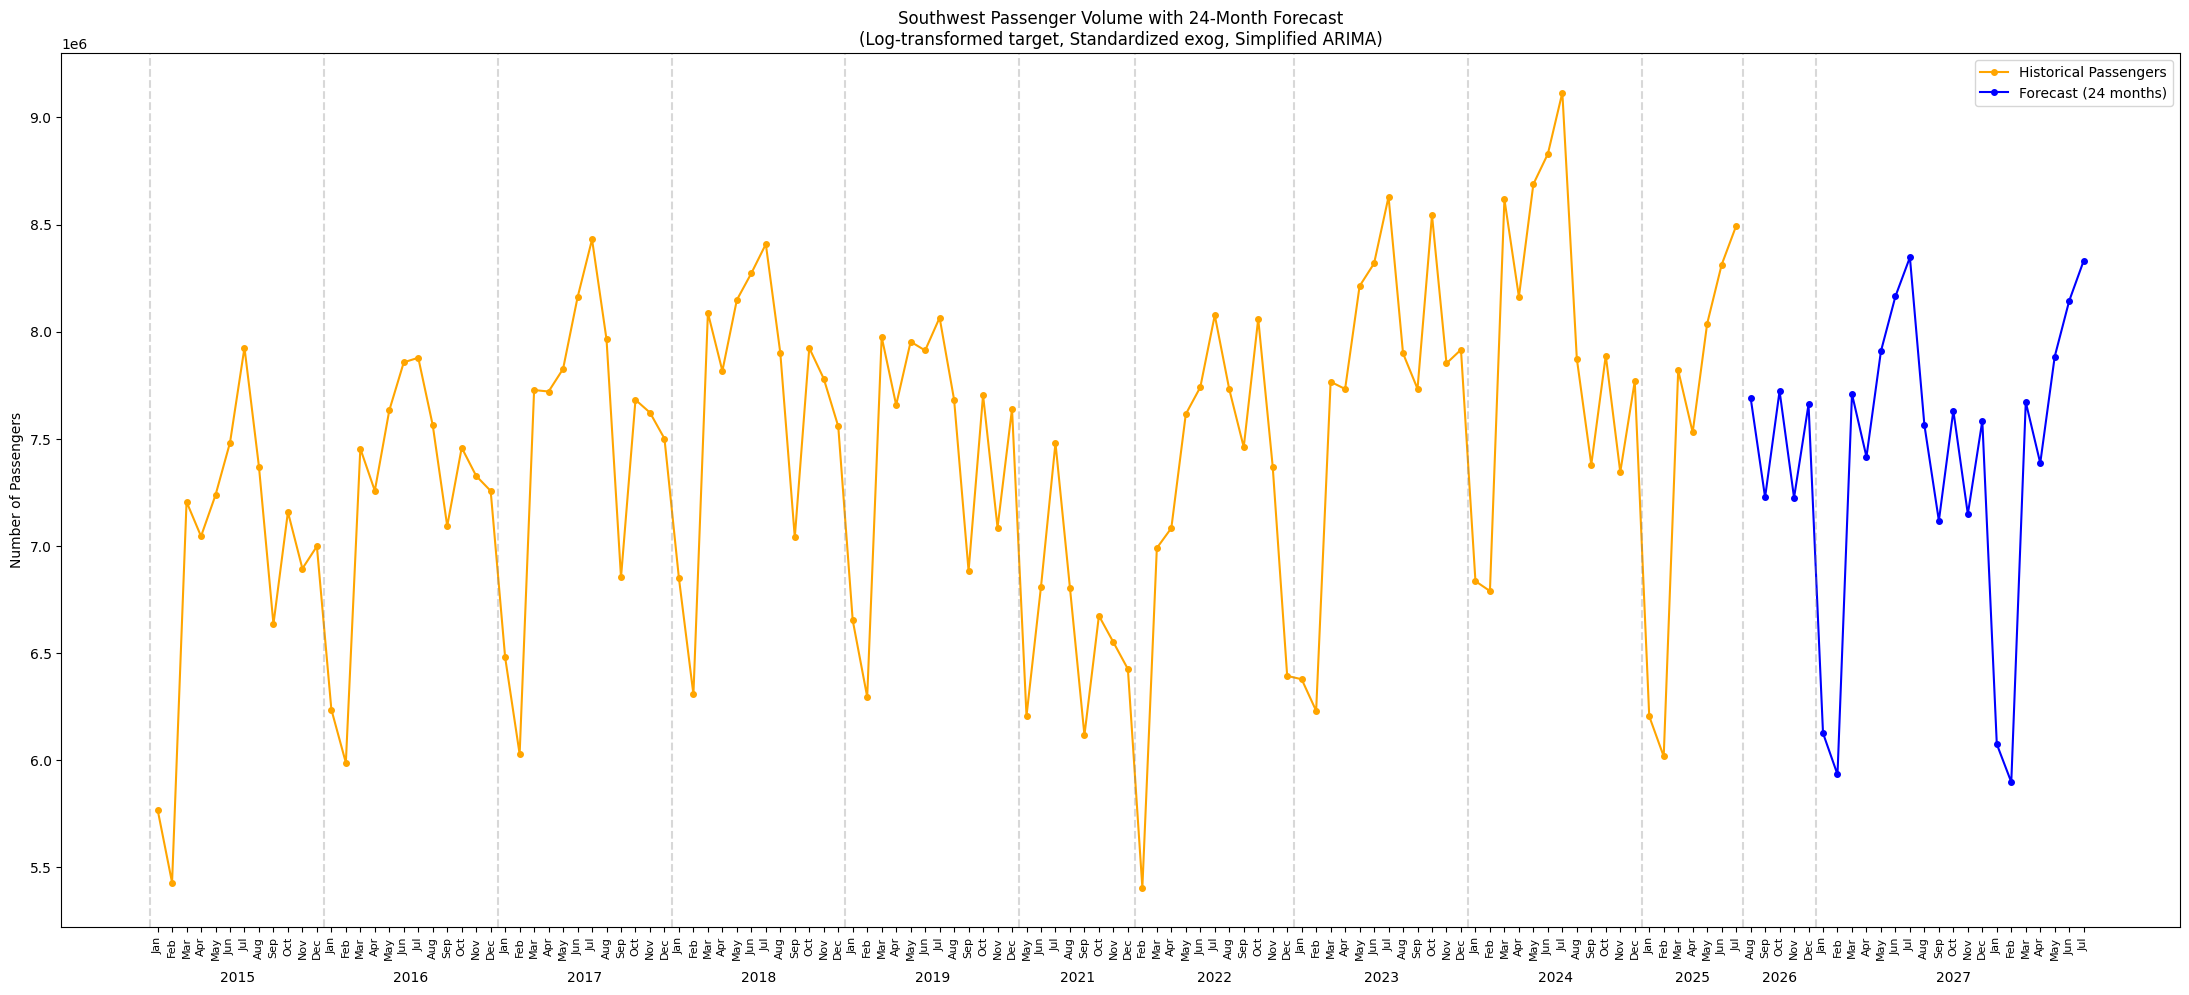


=== MODEL DIAGNOSTICS ===
                                SARIMAX Results                                 
Dep. Variable:                    TOTAL   No. Observations:                  110
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                 131.548
Date:                  Tue, 18 Nov 2025   AIC                           -255.096
Time:                          14:48:50   BIC                           -244.797
Sample:                               0   HQIC                          -250.931
                                  - 110                                         
Covariance Type:                    opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
airplane_fare_cpi     0.0152      0.005      2.868      0.004       0.005       0.026
fed_fund_rate         0.0521      0.008      6.415      0.000      

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

# Define month mapping
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

df_passengers = pd.read_csv("net_csvpassengers.csv")
df_passengers = df_passengers.drop(columns=['DOMESTIC', 'INTERNATIONAL'])

# DROP COVID outliers
df_passengers = df_passengers.drop([60, 61, 62, 63, 72])
df_passengers = df_passengers.reset_index(drop=True)

# Load the three external data files
df_airfare = pd.read_csv('airfarecpi.csv')
df_fedfunds = pd.read_csv('FEDFUNDS.csv')
df_unemployment = pd.read_csv('unemployment_rate_historical_and_forecast.csv')

# Standardize date column names
df_airfare.columns = ['date', 'airplane_fare_cpi']
df_fedfunds.columns = ['date', 'fed_fund_rate']
df_unemployment.columns = ['date', 'unemployment_rate']

# Create a date column in df_passengers in YYYY-MM format
df_passengers['date'] = df_passengers['Year'].astype(str) + '-' + df_passengers['Month'].astype(str).str.zfill(2)

print("=== DATA VALIDATION ===")
print(f"Passenger data range: {df_passengers['date'].min()} to {df_passengers['date'].max()}")
print(f"Airfare data range: {df_airfare['date'].min()} to {df_airfare['date'].max()}")
print(f"Fed funds data range: {df_fedfunds['date'].min()} to {df_fedfunds['date'].max()}")
print(f"Unemployment data range: {df_unemployment['date'].min()} to {df_unemployment['date'].max()}")

# Merge all external variables with passenger data
df_merged = df_passengers.copy()
df_merged = df_merged.merge(df_airfare, on='date', how='left')
df_merged = df_merged.merge(df_fedfunds, on='date', how='left')
df_merged = df_merged.merge(df_unemployment, on='date', how='left')

print(f"\nRows before dropping NaNs: {len(df_merged)}")
print(f"NaNs in airplane_fare_cpi: {df_merged['airplane_fare_cpi'].isna().sum()}")
print(f"NaNs in fed_fund_rate: {df_merged['fed_fund_rate'].isna().sum()}")
print(f"NaNs in unemployment_rate: {df_merged['unemployment_rate'].isna().sum()}")

# Drop rows with missing values in exogenous variables
df_merged = df_merged.dropna(subset=['airplane_fare_cpi', 'fed_fund_rate', 'unemployment_rate'])
df_merged = df_merged.reset_index(drop=True)
print(f"Rows after dropping NaNs: {len(df_merged)}")

# Determine the minimum forecast horizon from the three files
last_passenger_date = df_merged['date'].iloc[-1]
last_passenger_date_dt = pd.to_datetime(last_passenger_date + '-01')

# Get the last available date for each external variable
last_airfare_date = pd.to_datetime(df_airfare['date'].iloc[-1] + '-01')
last_fedfunds_date = pd.to_datetime(df_fedfunds['date'].iloc[-1] + '-01')
last_unemployment_date = pd.to_datetime(df_unemployment['date'].iloc[-1] + '-01')

# Calculate months available for forecasting from each source
months_airfare = (last_airfare_date.year - last_passenger_date_dt.year) * 12 + (last_airfare_date.month - last_passenger_date_dt.month)
months_fedfunds = (last_fedfunds_date.year - last_passenger_date_dt.year) * 12 + (last_fedfunds_date.month - last_passenger_date_dt.month)
months_unemployment = (last_unemployment_date.year - last_passenger_date_dt.year) * 12 + (last_unemployment_date.month - last_passenger_date_dt.month)

# Use the minimum available forecast horizon
forecast_steps = min(24, months_airfare, months_fedfunds, months_unemployment)
print(f"\n=== FORECAST HORIZON ===")
print(f"Forecast horizon limited to {forecast_steps} months based on available external data")
print(f"  - Airfare CPI: {months_airfare} months available")
print(f"  - Fed Funds Rate: {months_fedfunds} months available")
print(f"  - Unemployment Rate: {months_unemployment} months available")

# Generate forecast dates
forecast_dates = pd.date_range(start=last_passenger_date_dt + pd.DateOffset(months=1),
                                periods=forecast_steps, freq='MS')
forecast_dates_str = forecast_dates.strftime('%Y-%m')

# Prepare exogenous variables for forecasting
exog_forecast_list = []
for date_str in forecast_dates_str:
    airfare_val = df_airfare[df_airfare['date'] == date_str]['airplane_fare_cpi'].values
    fedfunds_val = df_fedfunds[df_fedfunds['date'] == date_str]['fed_fund_rate'].values
    unemployment_val = df_unemployment[df_unemployment['date'] == date_str]['unemployment_rate'].values

    exog_forecast_list.append({
        'airplane_fare_cpi': airfare_val[0] if len(airfare_val) > 0 else np.nan,
        'fed_fund_rate': fedfunds_val[0] if len(fedfunds_val) > 0 else np.nan,
        'unemployment_rate': unemployment_val[0] if len(unemployment_val) > 0 else np.nan
    })

exog_forecast = pd.DataFrame(exog_forecast_list)

# CHECK 1: Verify no NaNs in exog_forecast
print(f"\n=== EXOGENOUS FORECAST VALIDATION ===")
print(f"NaNs in forecast airplane_fare_cpi: {exog_forecast['airplane_fare_cpi'].isna().sum()}")
print(f"NaNs in forecast fed_fund_rate: {exog_forecast['fed_fund_rate'].isna().sum()}")
print(f"NaNs in forecast unemployment_rate: {exog_forecast['unemployment_rate'].isna().sum()}")

if exog_forecast.isna().any().any():
    print("WARNING: NaNs detected in exog_forecast! This will cause errors.")
    print(exog_forecast[exog_forecast.isna().any(axis=1)])
else:
    print("✓ No NaNs in exog_forecast - good to proceed!")

# CHECK 2: Verify 1:1 date alignment
print(f"\n=== DATE ALIGNMENT CHECK ===")
print(f"Training data: {len(df_merged)} rows from {df_merged['date'].iloc[0]} to {df_merged['date'].iloc[-1]}")
print(f"Forecast data: {len(exog_forecast)} rows from {forecast_dates_str[0]} to {forecast_dates_str[-1]}")
print(f"✓ Date alignment confirmed")

# CHECK 3: Standardize exogenous variables
print(f"\n=== STANDARDIZING EXOGENOUS VARIABLES ===")
exog_cols = ['airplane_fare_cpi', 'fed_fund_rate', 'unemployment_rate']

# Store original values for inverse transformation
exog_train_raw = df_merged[exog_cols].copy()
exog_forecast_raw = exog_forecast.copy()

# Fit scaler on training data
scaler = StandardScaler()
exog_train_scaled = pd.DataFrame(
    scaler.fit_transform(exog_train_raw),
    columns=exog_cols,
    index=exog_train_raw.index
)

# Transform forecast data using the same scaler
exog_forecast_scaled = pd.DataFrame(
    scaler.transform(exog_forecast_raw),
    columns=exog_cols,
    index=exog_forecast_raw.index
)

print("Training data statistics (after scaling):")
print(exog_train_scaled.describe())
print("\nForecast data statistics (after scaling):")
print(exog_forecast_scaled.describe())

# CHECK 4: Log-transform the target to stabilize variance
print(f"\n=== LOG-TRANSFORMING TARGET VARIABLE ===")
log_total = np.log(df_merged['TOTAL'])
print(f"Original TOTAL - Mean: {df_merged['TOTAL'].mean():.2f}, Std: {df_merged['TOTAL'].std():.2f}")
print(f"Log(TOTAL) - Mean: {log_total.mean():.4f}, Std: {log_total.std():.4f}")

# CHECK 5: Simplify AR/MA terms (use simpler structure)
print(f"\n=== FITTING SARIMAX MODEL ===")
print("Using simplified ARIMA structure: order=(0,0,0), seasonal_order=(0,1,0,12)")
print("(Non-significant AR/MA terms removed)")

# Fit SARIMAX model with simplified structure and standardized exog
model = SARIMAX(log_total,
                exog=exog_train_scaled,
                order=(0,0,0),  # Simplified - no AR/MA terms
                seasonal_order=(0,1,0,12),  # Seasonal differencing only
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

# Generate forecast
forecast = results.get_forecast(steps=forecast_steps, exog=exog_forecast_scaled)
forecast_values_log = forecast.predicted_mean

# Back-transform from log scale
forecast_values = np.exp(forecast_values_log)

# Also get confidence intervals and back-transform
forecast_ci = forecast.conf_int()
forecast_ci_lower = np.exp(forecast_ci.iloc[:, 0])
forecast_ci_upper = np.exp(forecast_ci.iloc[:, 1])

# Create forecast DataFrame and save to CSV
forecast_df = pd.DataFrame({
    'month': forecast_dates_str,
    'passenger_volume': forecast_values.values,
    'lower_ci_95': forecast_ci_lower.values,
    'upper_ci_95': forecast_ci_upper.values
})
forecast_df.to_csv('passenger_forecast_24months.csv', index=False)
print("\n✓ CSV file saved: passenger_forecast_24months.csv")
print(forecast_df.head())

# Plotting
x = np.arange(len(df_merged) + forecast_steps)
plt.figure(figsize=(22,10))

# Plot historical passenger data
plt.plot(np.arange(len(df_merged)), df_merged['TOTAL'],
         marker='o', color='orange', label='Historical Passengers', markersize=4)

# Plot forecast data
plt.plot(np.arange(len(df_merged), len(df_merged)+forecast_steps), forecast_values,
         marker='o', color='blue', label=f'Forecast ({forecast_steps} months)', markersize=4)

'''
# Add confidence intervals
plt.fill_between(np.arange(len(df_merged), len(df_merged)+forecast_steps),
                 forecast_ci_lower, forecast_ci_upper,
                 color='blue', alpha=0.2, label='95% Confidence Interval')
'''

plt.title(f'Southwest Passenger Volume with {forecast_steps}-Month Forecast\n(Log-transformed target, Standardized exog, Simplified ARIMA)')
plt.ylabel('Number of Passengers')

# Generate all month labels (historical + forecast)
all_months = [month_map[int(m)] if isinstance(m, (int, np.integer)) else m for m in df_merged['Month'].tolist()]
last_month_num = int(df_merged['Month'].iloc[-1])

for i in range(1, forecast_steps + 1):
    next_month_num = last_month_num + i
    month_val = (next_month_num - 1) % 12 + 1
    forecast_month_str = month_map[month_val]
    all_months.append(forecast_month_str)

plt.xticks(x, all_months, fontsize=8, rotation=90)

# Vertical lines and year labels for historical data
for y in df_merged['Year'].unique():
    year_indices = df_merged.index[df_merged['Year'] == y].tolist()
    if year_indices:
        start_index = year_indices[0]
        end_index = year_indices[-1]
        midpoint = (start_index + end_index) / 2
        plt.axvline(x=start_index - 0.5, color='gray', linestyle='--', alpha=0.3)
        plt.text(midpoint, plt.ylim()[0] - 0.05*(plt.ylim()[1]-plt.ylim()[0]), str(y),
                 ha='center', va='top', fontsize=10, color='black')

# Handle forecast years
forecast_start_index = len(df_merged)
last_year = df_merged['Year'].iloc[-1]
last_month_num = int(df_merged['Month'].iloc[-1])
months_in_first_year = 12 - last_month_num

if months_in_first_year > 0 and forecast_steps > months_in_first_year:
    forecast_year_1 = last_year + 1
    forecast_year_1_end = forecast_start_index + months_in_first_year - 1
    forecast_year_1_mid = (forecast_start_index + forecast_year_1_end) / 2
    plt.axvline(x=forecast_start_index - 0.5, color='gray', linestyle='--', alpha=0.3)
    plt.text(forecast_year_1_mid, plt.ylim()[0] - 0.05*(plt.ylim()[1]-plt.ylim()[0]),
             str(forecast_year_1), ha='center', va='top', fontsize=10, color='black')

    if forecast_steps > months_in_first_year:
        forecast_year_2 = last_year + 2
        forecast_year_2_start = forecast_start_index + months_in_first_year
        forecast_year_2_end = forecast_start_index + forecast_steps - 1
        forecast_year_2_mid = (forecast_year_2_start + forecast_year_2_end) / 2
        plt.axvline(x=forecast_year_2_start - 0.5, color='gray', linestyle='--', alpha=0.3)
        plt.text(forecast_year_2_mid, plt.ylim()[0] - 0.05*(plt.ylim()[1]-plt.ylim()[0]),
                 str(forecast_year_2), ha='center', va='top', fontsize=10, color='black')
else:
    forecast_year_1 = last_year + 1
    forecast_year_1_mid = forecast_start_index + forecast_steps / 2
    plt.axvline(x=forecast_start_index - 0.5, color='gray', linestyle='--', alpha=0.3)
    plt.text(forecast_year_1_mid, plt.ylim()[0] - 0.05*(plt.ylim()[1]-plt.ylim()[0]),
             str(forecast_year_1), ha='center', va='top', fontsize=10, color='black')

plt.tight_layout()
plt.legend()
plt.show()

# Print model summary
print("\n=== MODEL DIAGNOSTICS ===")
print(results.summary())
print("\nP-values:")
print(results.pvalues)
print(f"\nSigma2 (residual variance): {results.params['sigma2']:.6f}")
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")

# Residual diagnostics
residuals = results.resid
print(f"\nResidual statistics:")
print(f"  Mean: {residuals.mean():.6f}")
print(f"  Std: {residuals.std():.6f}")
print(f"  Min: {residuals.min():.6f}")
print(f"  Max: {residuals.max():.6f}")

# === MAPE (In-sample) ===
def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0  # avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# In-sample predictions on the log scale, then back-transform
insample_pred_log = results.get_prediction(exog=exog_train_scaled).predicted_mean
insample_pred = np.exp(insample_pred_log)  # same back-transform used for forecast

actual = df_merged['TOTAL'].to_numpy()
insample_mape = mape(actual, insample_pred)
print(f"\n=== PERFORMANCE ===")
print(f"In-sample MAPE: {insample_mape:.2f}%")
